# Magic Squares Game Optimization

In this notebook, we demonstrate the use of variational quantum optimization (VQO) to find optimal quantum strategies for the magic squares game.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

import qnetvo as qnet

## Finding the Perfect Winning Probability

The magic squares game and the optimal quantum strategy are described in https://arxiv.org/abs/quant-ph/0407221.
The magic squares cost function minimizes $-P_{\text{Win}}$ and is outlined in more detail in the `qnetvo` docs.

### Optimizing Measurments for Fixed State Preparations

In this section, we will optimize arbitrary two-qubit measurements against different state preparations including, a 4-qubit GHZ state, two copies of a Bell state, a single Bell state, and no entanglement.
Each optimization will be performed on 4-qubit wires.

In [2]:
bell_copies_prep_node = [
    qnet.PrepareNode(1, [0,1,2,3], qnet.bell_state_copies, 0)
]
ghz_prep_node = [
    qnet.PrepareNode(1, [0,1,2,3], qnet.ghz_state, 0)
]
max_entangled_prep_node = [
    qnet.PrepareNode(1, [0,2], qnet.max_entangled_state, 3)
]
classical_prep_node = [
    qnet.PrepareNode(1, [0,1,2,3], lambda settings, wires: None, 0)
]

measure_nodes = [
    qnet.MeasureNode(3, 4, [0,1], qml.ArbitraryUnitary, 15),
    qnet.MeasureNode(3, 4, [2,3], qml.ArbitraryUnitary, 15),
]

classical_ansatz = qnet.NetworkAnsatz(classical_prep_node, measure_nodes)
max_entangled_ansatz = qnet.NetworkAnsatz(max_entangled_prep_node, measure_nodes)
ghz_state_ansatz = qnet.NetworkAnsatz(ghz_prep_node, measure_nodes)
bell_copies_ansatz = qnet.NetworkAnsatz(bell_copies_prep_node, measure_nodes)

Next, we perform gradient descent to minimze the magic squares cost function with respect to each of the above state preparations.

## Classical State Preparation

In [3]:
%%time
np.random.seed(2)

classical_opt_dict = qnet.gradient_descent(
    qnet.magic_squares_game_cost_fn(classical_ansatz),
    classical_ansatz.rand_network_settings(),
    step_size=3.5,
    num_steps=100,
    sample_width=5,
    verbose=False
)

print("opt score : ", classical_opt_dict["opt_score"])

opt score :  0.8888798713795557
CPU times: user 57.9 s, sys: 777 ms, total: 58.7 s
Wall time: 1min


## 4-Qubit GHZ State Preparation

In [4]:
%%time
np.random.seed(2)

ghz_state_opt_dict = qnet.gradient_descent(
    qnet.magic_squares_game_cost_fn(ghz_state_ansatz),
    ghz_state_ansatz.rand_network_settings(),
    step_size=3.5,
    num_steps=100,
    sample_width=5,
    verbose=False
)

print("opt score : ", ghz_state_opt_dict["opt_score"])

opt score :  0.9552447018371052
CPU times: user 1min 14s, sys: 1.11 s, total: 1min 15s
Wall time: 1min 18s


## Arbitrary Maximally Entangled 2-Qubit State Preparation

In [5]:
%%time
np.random.seed(1)

max_entangled_opt_dict = qnet.gradient_descent(
    qnet.magic_squares_game_cost_fn(max_entangled_ansatz),
    max_entangled_ansatz.rand_network_settings(),
    step_size=2,
    num_steps=100,
    sample_width=5,
    verbose=True
)

print("opt score : ", max_entangled_opt_dict["opt_score"])

iteration :  0 , score :  0.4851396844059196
elapsed time :  0.48635411262512207
iteration :  5 , score :  0.658387385514294
elapsed time :  0.5488309860229492
iteration :  10 , score :  0.7032587972803017
elapsed time :  0.5276150703430176
iteration :  15 , score :  0.733221432481375
elapsed time :  0.45144104957580566
iteration :  20 , score :  0.7604316515863423
elapsed time :  0.5519330501556396
iteration :  25 , score :  0.7851542492948232
elapsed time :  0.5049970149993896
iteration :  30 , score :  0.8094369348466013
elapsed time :  0.435499906539917
iteration :  35 , score :  0.8443960620540358
elapsed time :  0.5274088382720947
iteration :  40 , score :  0.8840567175931876
elapsed time :  0.5031859874725342
iteration :  45 , score :  0.9084930323464833
elapsed time :  0.4725611209869385
iteration :  50 , score :  0.9241414919537697
elapsed time :  0.5196230411529541
iteration :  55 , score :  0.9349621587689507
elapsed time :  0.5121328830718994
iteration :  60 , score :  0.94

## Two Copies of a Bell State

In [6]:
%%time
np.random.seed(2)

bell_copies_opt_dict = qnet.gradient_descent(
    qnet.magic_squares_game_cost_fn(bell_copies_ansatz),
    bell_copies_ansatz.rand_network_settings(),
    step_size=3.5,
    num_steps=100,
    sample_width=5,
    verbose=False
)

print("opt score : ", bell_copies_opt_dict["opt_score"])

opt score :  0.9998940339308672
CPU times: user 46.8 s, sys: 235 ms, total: 47 s
Wall time: 47.4 s


## Plotting Optimization Data

The optimization data is shown in the plot below.
As expected, we find that the classical ansatz to achieve the classical bound and the two Bell states to achieve the quantum bound.
We find that a single maximally entangeld 2-qubit state provides an improvement over the lower bound.
Similarly, a 4-qubit GHZ state achieves the same score as a 2-qubit maximally entangled state.

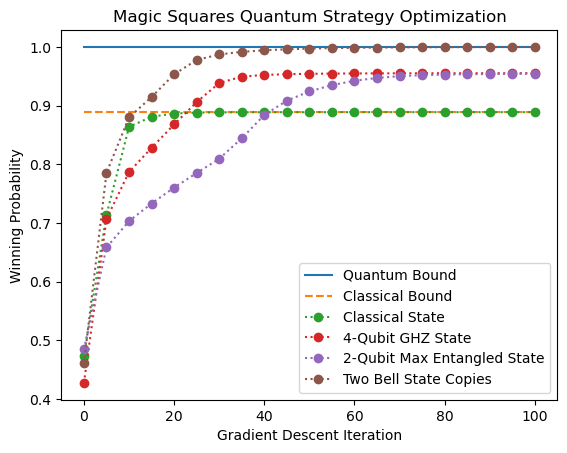

In [7]:
samples = bell_copies_opt_dict["samples"]

plt.plot(samples, [1] * len(samples), label = "Quantum Bound")
plt.plot(samples, [8/9] * len(samples), "--", label = "Classical Bound")

plt.plot(samples, classical_opt_dict["scores"], "o:", label="Classical State")
plt.plot(samples, ghz_state_opt_dict["scores"], "o:", label = "4-Qubit GHZ State")
plt.plot(samples, max_entangled_opt_dict["scores"], "o:", label="2-Qubit Max Entangled State")
plt.plot(samples, bell_copies_opt_dict["scores"], "o:", label = "Two Bell State Copies")

plt.title("Magic Squares Quantum Strategy Optimization")
plt.xlabel("Gradient Descent Iteration")
plt.ylabel("Winning Probability")
plt.legend()
plt.show()